# Access to public EPN-TAP data services through Jupyter notebook

In [1]:
import pyvo as vo
from matplotlib import pyplot as plt
from astropy.table import Table
import urllib
#  beware that this is incompatible with IDLpy
from astroquery.utils.tap.core import TapPlus  
import astropy.io.votable as vot

## 1- Search an EPN-TAP data service
Example from VIRTIS / Venus-Express

Here we search a service in the registry from keywords.

In [2]:
# Search the VO registry for TAP services about the VIRTIS instrument

In [3]:
tap_services = vo.registry.search(servicetype='tap',keywords=['VIRTIS'], includeaux=True)
print(tap_services.to_table)

print('pyvo version: '+vo.__version__)
# will work in pyvo 1.5:
#r2 = vo.registry.search(datamodel="epntap")
#r2


<bound method DALResults.to_table of <Table length=3>
                 ivoid                        res_type      ... intf_roles
                                                            ...           
                 object                        object       ...   object  
---------------------------------------- ------------------ ... ----------
          ivo://cds.vizier/j/a+a/585/a53  vs:catalogservice ...        std
         ivo://cds.vizier/j/a+a/647/a119  vs:catalogservice ...        std
ivo://padc.obspm.planeto/vvex/q/epn_core vs:catalogresource ...        std>
pyvo version: 1.4.1


We manually choose a service that uses the epn-tap data model (can be automatized in pyvo 1.5)

In [4]:
tap_services = vo.registry.search(servicetype='tap',keywords=['VIRTIS'], ivoid='ivo://padc.obspm.planeto/vvex/q/epn_core', includeaux=True)
resource = tap_services[0]
mytable = list(resource.get_tables().keys())[0]
print('schema and table to query:',mytable)
myurl = resource.access_url
print('url of the TAP service:',myurl)
query = 'SELECT top 100 * FROM ' + mytable

schema and table to query: vvex.epn_core
url of the TAP service: http://voparis-tap-planeto.obspm.fr/tap


In [5]:
# query the EPN-TAP service with astroquery, retrieve all parameters for a few rows
virtis = TapPlus(myurl)
job = virtis.launch_job(query)
r1 = job.get_results()
print(r1)

granule_uid granule_gid   obs_id  ... science_case_id sc_pointing_mode
                                  ...                                 
----------- ----------- --------- ... --------------- ----------------
 VI0096_06G    geometry VI0096_06 ...               2        NADIR_POW
 VI0096_07C  calibrated VI0096_07 ...               2        NADIR_POW
 VI0096_07G    geometry VI0096_07 ...               2        NADIR_POW
 VI0096_08C  calibrated VI0096_08 ...               2        NADIR_POW
 VI0096_08G    geometry VI0096_08 ...               2        NADIR_POW
 VI0096_09C  calibrated VI0096_09 ...               2        NADIR_POW
 VI0096_09G    geometry VI0096_09 ...               2        NADIR_POW
 VI0096_10C  calibrated VI0096_10 ...               2        NADIR_POW
 VI0096_10G    geometry VI0096_10 ...               2        NADIR_POW
 VI0096_11C  calibrated VI0096_11 ...               2        NADIR_POW
 VI0096_11G    geometry VI0096_11 ...               2        NADIR_POW
 VI009

In [6]:
# query the EPN-TAP service with astroquery, retrieve selected granules and writes a VOTable
virtis = TapPlus(myurl)
query1 = 'SELECT * FROM ' + mytable + " WHERE granule_gid = 'calibrated' AND time_max <= 2453946.50000000 AND channel_id = 'VIRTIS_M_VIS'"
job = virtis.launch_job(query1)
resultset = job.get_results()
print(resultset)
vot.writeto(resultset, 'toto.vot')

granule_uid granule_gid   obs_id  ... science_case_id sc_pointing_mode
                                  ...                                 
----------- ----------- --------- ... --------------- ----------------
 VV0042_00C  calibrated VV0042_00 ...               7            INERT
 VV0028_00C  calibrated VV0028_00 ...               3           MOSAIC
 VV0026_04C  calibrated VV0026_04 ...               3           MOSAIC
 VV0099_06C  calibrated VV0099_06 ...               2        NADIR_POW
 VV0075_20C  calibrated VV0075_20 ...               1        NADIR_POW
 VV0075_19C  calibrated VV0075_19 ...               2        NADIR_POW
 VV0038_00C  calibrated VV0038_00 ...               2        NADIR_POW
 VV0028_07C  calibrated VV0028_07 ...               3           MOSAIC
 VV0029_01C  calibrated VV0029_01 ...               3           MOSAIC
 VV0028_04C  calibrated VV0028_04 ...               3           MOSAIC
 VV0029_07C  calibrated VV0029_07 ...               3           MOSAIC
 VV002

In [7]:
# Alternatively: query service with pyvo, writes a local VOtable
query1 = 'SELECT * FROM ' + mytable + " WHERE granule_gid = 'calibrated' AND time_max <= 2453946.50000000 AND channel_id = 'VIRTIS_M_VIS'"
service = vo.dal.TAPService(myurl)
resultset1 = service.search(query1)
# store query result locally
resultset1.to_table().write(output="result.vot", format="votable",overwrite="True")

In [8]:
# extract start times
timemin = (resultset1['time_min'])
#timemin

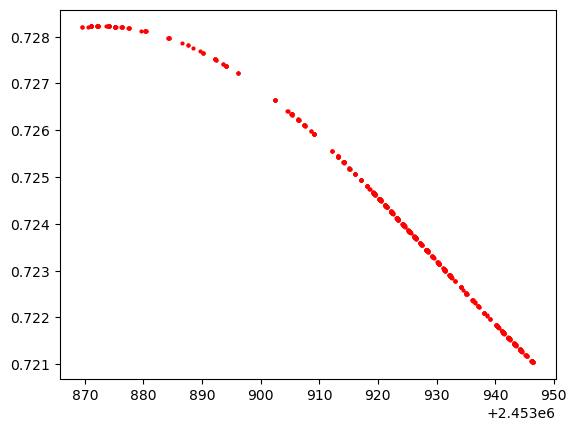

In [9]:
# plots solar distance vs time of session
sundist = (resultset1['sun_distance_min'])
p = plt.plot(timemin, sundist, 'ro', ms=2)

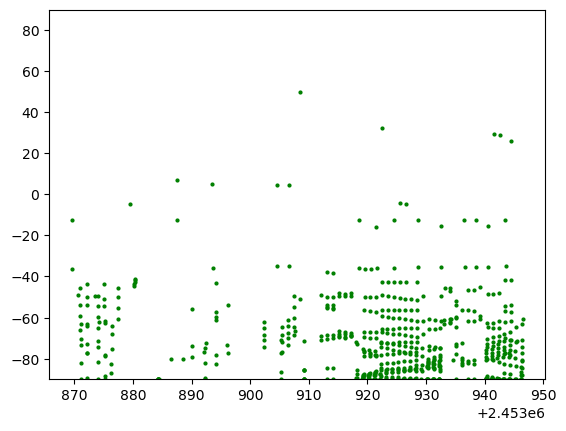

In [10]:
# plots Southernmost latitude vs time of session
lat = (resultset1['c2min'])
p = plt.plot(timemin, lat, 'go', ms=2)
p = plt.ylim(-90,90)

Such plots can be used to monitor instrument or observational parameters included in the metadata table

## 2- Use TOPCAT to manipulate metadata outside of Jupyter notebook

Metadata are sent to TOPCAT using the Stilts scripting language (distributed with TOPCAT)
- can be declared in Unix path, typically: set path = ($path /Applications/ApplisAstro/topcat/bin)
- (adjust to your own system - Stilts may be embded in the TOPCAT bundle on Mac)

In [12]:
# with TOPCAT open => send the table there for manipulation
!/Applications/ApplisAstro/topcat/TOPCAT.app/Contents/Resources/bin/stilts tpipe ifmt=votable in=result.vot omode=topcat

Metadata can then be plotted interactively inside TOPCAT

Stilts can also be used as an external plotting tool (no need to launch TOPCAT)

In [13]:
!/Applications/ApplisAstro/topcat/TOPCAT.app/Contents/Resources/bin/stilts plot2plane layer1=mark ifmt1=votable in1=result.vot \
 ymax=90 x1=time_min y1=c2min

Quit Stilts when you're done

## 3- Retrieve a data file

Assuming the file of interest is already identified

In [14]:
#only retrieves access_url for granule of interest
service = vo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap")

resultset = service.search("select * from vvex.epn_core where granule_uid = 'VI0025_08C'")
print(resultset.fieldnames)

('granule_uid', 'granule_gid', 'obs_id', 'dataproduct_type', 'target_name', 'target_class', 'time_min', 'time_max', 'time_sampling_step_min', 'time_sampling_step_max', 'time_exp_min', 'time_exp_max', 'spectral_range_min', 'spectral_range_max', 'spectral_sampling_step_min', 'spectral_sampling_step_max', 'spectral_resolution_min', 'spectral_resolution_max', 'c1min', 'c1max', 'c2min', 'c2max', 'c3min', 'c3max', 's_region', 'c1_resol_min', 'c1_resol_max', 'c2_resol_min', 'c2_resol_max', 'c3_resol_min', 'c3_resol_max', 'spatial_frame_type', 'incidence_min', 'incidence_max', 'emergence_min', 'emergence_max', 'phase_min', 'phase_max', 'instrument_host_name', 'instrument_name', 'measurement_type', 'processing_level', 'creation_date', 'modification_date', 'release_date', 'service_title', 'access_url', 'access_format', 'access_estsize', 'time_scale', 'thumbnail_url', 'file_name', 'publisher', 'bib_reference', 'sun_distance_min', 'sun_distance_max', 'target_distance_min', 'target_distance_max', '

In [15]:
for row in resultset:
     print(row['access_url'])

https://archives.esac.esa.int/psa/ftp/VENUS-EXPRESS/VIRTIS/VEX-V-VIRTIS-2-3-V3.0/DATA/MTP001/VIR0025/CALIBRATED/VI0025_08.CAL


This particular service provides links to files in the PSA archive

In [16]:
# no longer works?
#url = row.getdataurl()
#url
# this is OK
url = resultset['access_url', 0]
url

'https://archives.esac.esa.int/psa/ftp/VENUS-EXPRESS/VIRTIS/VEX-V-VIRTIS-2-3-V3.0/DATA/MTP001/VIR0025/CALIBRATED/VI0025_08.CAL'

In [17]:
file_name = resultset['file_name', 0]
file_name

'VI0025_08.CAL'

In [20]:
# fetch file where indicated
## urllib.request.urlretrieve(url, filename=file_name)

Wait for the file to download

## 4- Reading and plotting the data

See Tutorial VVEX_demo_private.ipynb to learn how to read PDS3 files under IDL in the notebook. 
Beware IDLpy seems incompatible with astropy (IDL will crash if astropy is loaded)